In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from IPython.display import Image
import us
import numpy as np
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
%matplotlib inline

<h2><b>Descrição:
Tweets coletados recentemente sobre as vacinas da Pfizer & BioNTech. Foi utilizado o Twitter API para a coleta dos dados.</b></h2>

Base de dados disponível em:
https://www.kaggle.com/gpreda/pfizer-vaccine-tweets


Motivações e questões para serem respondidas:

- Quais são as localizações que vieram a maior quantidade de tweets sobre a pfizer?
- Quais as datas que tiveram a maior quantidade de tweets sobre a vacina e por qual motivo?
- Quais tweets com maior quantidade de "favorites" e "retweets"?
- Quais são os sentimentos das pessoas?
- Quais foram os perfis mais citados?
- O que as pessoas falavam em dias que os sentimentos eram mais baixos?
- O que elas falavam em dias que os sentimentos eram mais altos?
- Pessoas com sentimentos negativos costumam escrever tweets maiores do que as com sentimentos positivos?

Notebook utilizado como motivação:
https://www.kaggle.com/shreyasajal/pfizer-vaccine-tweets-vader-sentiment-analysis-eda

Demais recursos utilizados:
https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [2]:
pfizer = pd.read_csv("vaccination_tweets.csv")

In [3]:
pfizer.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
pfizer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2654 entries, 0 to 2653
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2654 non-null   int64 
 1   user_name         2654 non-null   object
 2   user_location     2103 non-null   object
 3   user_description  2523 non-null   object
 4   user_created      2654 non-null   object
 5   user_followers    2654 non-null   int64 
 6   user_friends      2654 non-null   int64 
 7   user_favourites   2654 non-null   int64 
 8   user_verified     2654 non-null   bool  
 9   date              2654 non-null   object
 10  text              2654 non-null   object
 11  hashtags          1981 non-null   object
 12  source            2653 non-null   object
 13  retweets          2654 non-null   int64 
 14  favorites         2654 non-null   int64 
 15  is_retweet        2654 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 295.6+ KB


In [5]:
pfizer.describe()

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,2.654000e+03,2.654000e+03,2654.000000,2654.000000,2654.000000,2654.000000
mean,1.342225e+18,6.223384e+04,1167.909570,13242.842879,1.686134,10.428410
std,2.946314e+15,4.656657e+05,2425.972664,41031.978580,11.957734,72.958435
min,1.337728e+18,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.339568e+18,1.210000e+02,165.000000,344.250000,0.000000,0.000000
50%,1.341717e+18,6.060000e+02,446.500000,1623.500000,0.000000,1.000000
75%,1.344837e+18,2.819500e+03,1200.750000,9687.000000,1.000000,4.000000
max,1.347501e+18,1.371493e+07,64441.000000,924667.000000,446.000000,2129.000000


Podemos verificar abaixo que 3 colunas possuem alguns dados nulos.
Hashtags, user_location e user_description.

Para o tratamento desses dados será preenchido "No Hashtags", "No Location" e "No Description", o que de fato não irá interferir em nossa análise.

No processo de ETL será feito também a limpeza dos dados, garantindo que a coluna data esteja como data, string em string, além da criação de uma word cloud com as palavras e hashtags mais ditas nos tweets.

Também será feita a lematização do texto. Segue abaixo uma explicação do que é lematização. Retirada do seguinte site: https://www.computersciencemaster.com.br/2018/12/aula-04-lemmatizacao.html

"A lematização é o processo, efetivamente, de deflexionar uma palavra para determinar o seu lema (as flexões chamam-se lexemas). Por exemplo, as palavras gato, gata, gatos, gatas são todas formas do mesmo lema: gato. Igualmente, as palavras tiver, tenho, tinha, tem são do mesmo lema ter. E bom, melhor e ótimo são lexemas do lema bom."

"A lematização é útil quando queremos ver os usos de palavras em contextos sem importância das flexões. Por exemplo, para a criação e uso de índices ou na investigação linguística. Ninguém quer ficar obrigado a pesquisar todas as formas duma palavra para encontrá-la num texto. Se pesquisássemos gato, seria melhor ter quaisquer das quatro formas como resultado, não só a forma masculina singular. Ou ao investigar as preferências entre «ter de» e «ter que», seria possível pesquisar as ocorrências em toda flexão do verbo com uma pesquisa como TER lema de em vez de construir uma pesquisa como ter de + tenho de + tens de + tem de + temos de + ..."

In [6]:
print("% de dados nulos em cada coluna")
round((pfizer.isnull().sum()/len(pfizer["id"]))*100,2).sort_values(ascending = False)

% de dados nulos em cada coluna


hashtags            25.36
user_location       20.76
user_description     4.94
source               0.04
is_retweet           0.00
favorites            0.00
retweets             0.00
text                 0.00
date                 0.00
user_verified        0.00
user_favourites      0.00
user_friends         0.00
user_followers       0.00
user_created         0.00
user_name            0.00
id                   0.00
dtype: float64

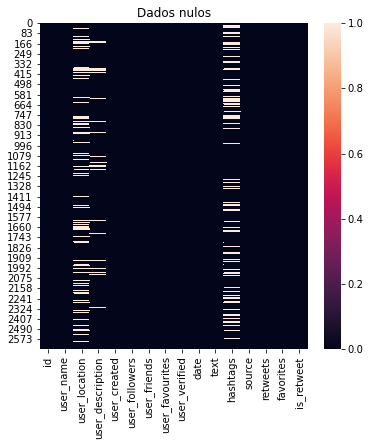

In [7]:
plt.figure(figsize=(6,6))
sns.heatmap(pfizer.isnull())
plt.title("Dados nulos");

In [8]:
pfizer["user_location"].fillna("No Location", inplace=True)
pfizer["user_location"] = pfizer["user_location"].astype(str)
pfizer["hashtags"].fillna("", inplace=True)
pfizer["user_description"].fillna("No Location", inplace=True)
pfizer["Comprimento Texto"] = pfizer["text"].apply(lambda x: int(len(x)))

In [9]:
def to_date_time(x):
    date = x.split()[0]
    date = datetime.strptime(date,'%Y-%m-%d')
    return date

pfizer["date"] = pfizer["date"].apply(lambda x: to_date_time(x))

In [10]:
# todas as palavras
def limpa_palavras(word):
    word = word.lower()
    word = re.sub(r"he's","he is", word)
    word = re.sub(r"i'm", "i am", word)
    word = re.sub(r"he's", "he is", word)
    word = re.sub(r"she's", "she is", word)
    word = re.sub(r"that's", "that is", word)        
    word = re.sub(r"what's", "what is", word)
    word = re.sub(r"where's", "where is", word) 
    word = re.sub(r"\'ll", " will", word)  
    word = re.sub(r"\'ve", " have", word)  
    word = re.sub(r"\'re", " are", word)
    word = re.sub(r"\'d", " would", word)
    word = re.sub(r"\'ve", " have", word)
    word = re.sub(r"won't", "will not", word)
    word = re.sub(r"don't", "do not", word)
    word = re.sub(r"did't", "did not", word)
    word = re.sub(r"can't", "can not", word)
    word = re.sub(r"it's", "it is", word)
    word = re.sub(r"couldn't", "could not", word)
    word = re.sub(r"have't", "have not", word)
    word = re.sub("https\S*|www.\S", "", word)
    word = re.sub("[,.#/:´^_+\"]", "", word)
    word = re.sub("[\']", "", word)
    word = re.sub("\$\S*|\(\S*\)", "",word)
    word = re.sub("\n", "", word)
    word = re.sub("https\S", "", word)
    word = re.sub("…", "", word)
    word = word.strip()
    return word

pfizer["texto_limpo"] = pfizer["text"].apply(lambda x: limpa_palavras(x))

In [11]:
def gerar_wordcloud(dataset,coluna, titulo):
    lista = []
    for words in dataset[coluna]:
        for word in words.split(","):
            word = re.sub("[\[\]']", "", word)
            word = word.strip()
            lista.append(word)
    lista = ", ".join(lista)
    
    wordcloud = WordCloud(width=1600, height=650,colormap="Blues", random_state=2).generate(lista)
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(titulo)
    plt.axis("off")

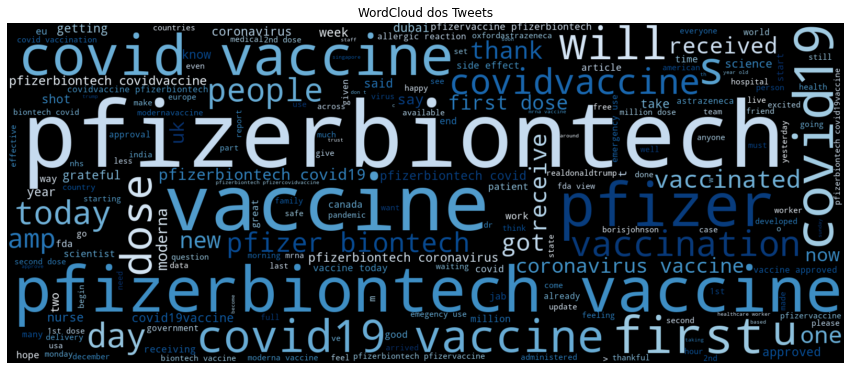

In [12]:
gerar_wordcloud(pfizer, "texto_limpo" , "WordCloud dos Tweets")

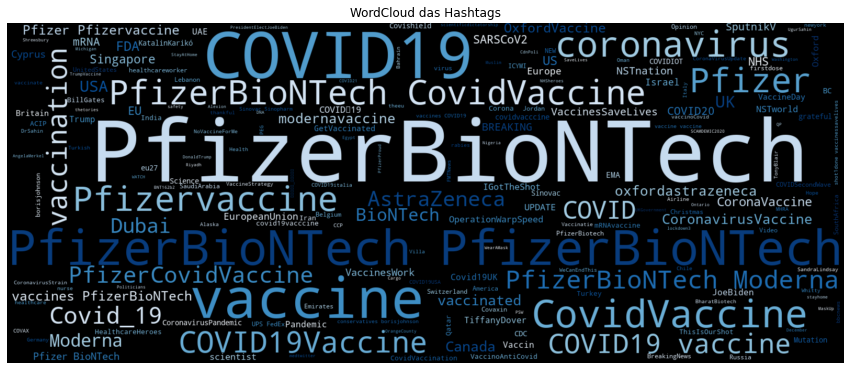

In [13]:
gerar_wordcloud(pfizer,"hashtags","WordCloud das Hashtags")

In [14]:
porter=PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [15]:
pfizer["text_stemming"] = pfizer["texto_limpo"].apply(lambda x: stemSentence(x))

In [16]:
pfizer["text_stemming"]

0       same folk said daikon past could treat a cytok...
1       while the world ha been on the wrong side of h...
2       coronaviru sputnikv astrazeneca pfizerbiontech...
3       fact are immut senat even when you are not eth...
4       explain to me again whi we need a vaccin @ bor...
                              ...                        
2649    happynewyearsev receiv my first dose of pfizer...
2650    thi open the way for regul worldwid to quickli...
2651    first dose of pfizerbiontech vaccin receiv the...
2652    💉✅⛔️to vax or not to vax ? ☪️check out my late...
2653    thi is in contrast to what @ bbchughpym ha jus...
Name: text_stemming, Length: 2654, dtype: object

In [54]:
texto_limpo = pfizer[["text","texto_limpo", "text_stemming"]]
print("Exemplo da diferença de um texto limpo e um não limpo:")
print("")
indice = 3
print(f"Texto conforme digitado: {texto_limpo['text'].loc[indice]}")
print(f"Texto limpo: {texto_limpo['texto_limpo'].loc[indice]}")
print(f"Texto limpo e realizado stemming: {texto_limpo['text_stemming'].loc[indice]}")

Exemplo da diferença de um texto limpo e um não limpo:

Texto conforme digitado: Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
Texto limpo: facts are immutable senator even when you are not ethically sturdy enough to acknowledge them  you were born i
Texto limpo e realizado stemming: fact are immut senat even when you are not ethic sturdi enough to acknowledg them you were born i 


In [18]:
lista = []
for words in pfizer["text"]:
    for word in words.split(","):
        word = word.strip()
        lista.append(word)
lista = ", ".join(lista)

In [19]:
marcacoes = re.findall("@[\S]*", lista)
marcacoes
marcacoes = pd.DataFrame(marcacoes)
marcacoes.columns=["Marcações"]
marcacoes["qtd"] = 1

In [20]:
def limpar_marcacoes(word):
    word = re.sub("[,.…]", "", word)
    word = re.sub("[.]", "",word)
    word = word.strip()
    if word == "@":
        word = ""
    return word

In [21]:
marcacoes["Marcações"] = marcacoes["Marcações"].apply(lambda x: limpar_marcacoes(x))
marcacoes = marcacoes[marcacoes["Marcações"]!=""]
marcacoes_top15 = marcacoes.groupby(by="Marcações").count().sort_values(by="qtd", ascending = False).head(15)

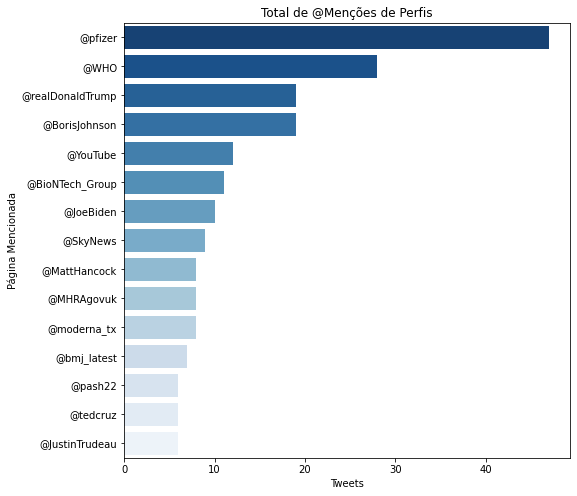

In [22]:
plt.figure(figsize = (8,8))
sns.barplot(y = marcacoes_top15.index, x=marcacoes_top15["qtd"], palette="Blues_r")
plt.title("Total de @Menções de Perfis")
plt.ylabel("Página Mencionada")
plt.xlabel("Tweets");

In [23]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    score = float(score.get("compound"))
    if score >=0.05:
        sentiment = "Positive"
    elif score <=(-0.05):
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return sentiment

In [24]:
def sentiment_analyzer_scores_number(text):
    score = analyser.polarity_scores(text)
    score = float(score.get("compound"))
    if score >=0.05:
        sentiment = 1
    elif score <=(-0.05):
        sentiment = -1
    else:
        sentiment = 0
    return sentiment

In [25]:
text_positive = "The phone is super cool."
text_negative = "The phone is fucking bad!!"

In [26]:
print(f"'{text_positive}' ===> Sentimento: {sentiment_analyzer_scores(text_positive)}")
print(f"'{text_negative}' ===> Sentimento: {sentiment_analyzer_scores(text_negative)}")

'The phone is super cool.' ===> Sentimento: Positive
'The phone is fucking bad!!' ===> Sentimento: Negative


In [27]:
pfizer["Sentimentos"] = pfizer["text"].apply(lambda x: sentiment_analyzer_scores(x))
pfizer["Sentimentos_number"] = pfizer["text"].apply(lambda x: sentiment_analyzer_scores_number(x))

In [28]:
pfizer[["text","Sentimentos"]].head()

,text,Sentimentos
0,Same folks said daikon paste could treat a cyt...,Positive
1,While the world has been on the wrong side of ...,Negative
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,Positive
3,"Facts are immutable, Senator, even when you're...",Neutral
4,Explain to me again why we need a vaccine @Bor...,Neutral


In [29]:
pfizer.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,hashtags,source,retweets,favorites,is_retweet,Comprimento Texto,texto_limpo,text_stemming,Sentimentos,Sentimentos_number
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,...,['PfizerBioNTech'],Twitter for Android,0,0,False,97,same folks said daikon paste could treat a cyt...,same folk said daikon past could treat a cytok...,Positive,1
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13,...,,Twitter Web App,1,1,False,140,while the world has been on the wrong side of ...,while the world ha been on the wrong side of h...,Negative,-1
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,140,coronavirus sputnikv astrazeneca pfizerbiontec...,coronaviru sputnikv astrazeneca pfizerbiontech...,Positive,1
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12,...,,Twitter Web App,446,2129,False,140,facts are immutable senator even when you are ...,fact are immut senat even when you are not eth...,Neutral,0
4,1337854064604966912,Citizen News Channel,No Location,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12,...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,135,explain to me again why we need a vaccine @bor...,explain to me again whi we need a vaccin @ bor...,Neutral,0


In [30]:
sentimentos_valores = pfizer.groupby(by="Sentimentos").count()
sentimentos_valores["%"] = round((sentimentos_valores["id"] / sum(sentimentos_valores["id"]) * 100),2)
sentimentos_valores = sentimentos_valores[["id", "%"]].sort_values(by="%", ascending = False)
sentimentos_valores.columns = ["Tweets", "%"]
sentimentos_valores

,Tweets,%
Sentimentos,,
Neutral,1112,41.90
Positive,1101,41.48
Negative,441,16.62


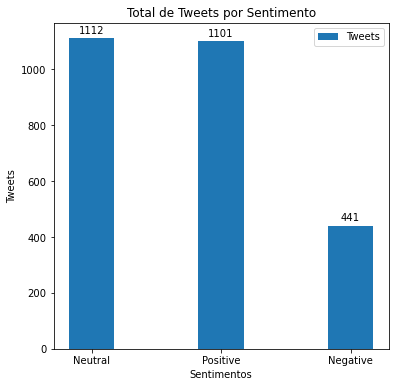

In [31]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
labels = sentimentos_valores.index
valores = sentimentos_valores["Tweets"]
x = np.arange(len(labels))  # the label locations


fig, ax = plt.subplots(figsize=(6,6))
width = 0.35  # the width of the bars
rects1 = ax.bar(x, valores, width, label='Tweets')
ax.set_ylabel('Tweets')
ax.set_xlabel("Sentimentos")
ax.set_title('Total de Tweets por Sentimento')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1)

In [32]:
sentimentos = pfizer.groupby(by=["date", "Sentimentos"]).agg({"hashtags":"count"}).reset_index()
sentimentos.columns = ["Data", "Sentimentos", "Tweets"]
medias_sentimentos = pfizer[["date", "Sentimentos_number"]].groupby(pd.Grouper(key='date', freq='d')).sum()

In [33]:
sentimentos.head()

,Data,Sentimentos,Tweets
0,2020-12-12,Negative,10
1,2020-12-12,Neutral,28
2,2020-12-12,Positive,25
3,2020-12-13,Negative,14
4,2020-12-13,Neutral,47


<AxesSubplot:title={'center':'Sentimentos de acordo com o tempo'}, xlabel='Data', ylabel='Tweets'>

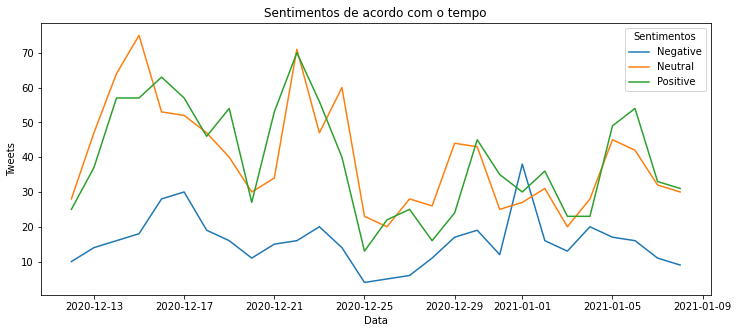

In [34]:
plt.figure(figsize =(12,5))
plt.title("Sentimentos de acordo com o tempo")
sns.lineplot(x=sentimentos["Data"], y="Tweets", data=sentimentos, hue="Sentimentos")

Text(0, 0.5, 'Sentimentos')

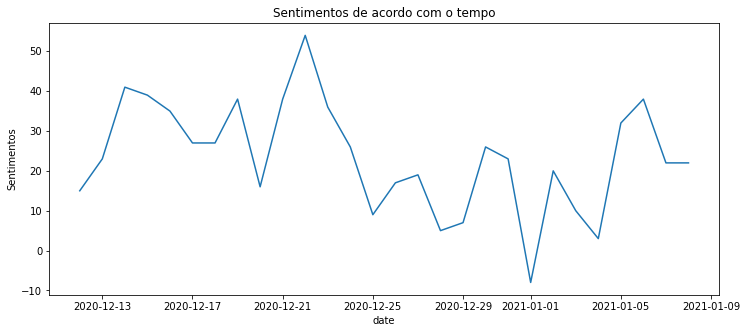

In [35]:
plt.figure(figsize =(12,5))
plt.title("Sentimentos de acordo com o tempo")
sns.lineplot(x=medias_sentimentos.index, y="Sentimentos_number", data=medias_sentimentos)
plt.ylabel("Sentimentos")

In [36]:
medias_sentimentos.sort_values("Sentimentos_number", ascending = False).head()

,Sentimentos_number
date,
2020-12-22,54
2020-12-14,41
2020-12-15,39
2020-12-21,38
2020-12-19,38


Analisando os dois gráficos anteriores, verificamos que existe um pico negativo de sentimento na data 01/01/2021 e um pico positivo de sentimento no dia 22/12/2020. Pesquisando na internet podemos encontrar que o pico positivo foi pela aprovação da vacina da Pfizer na europa um dia antes. Em seguida podemos verificar alguns tweets de sentimento negativo do dia 01/01/2021. Alguns deles cita uma morte um dia após ser vacinada.

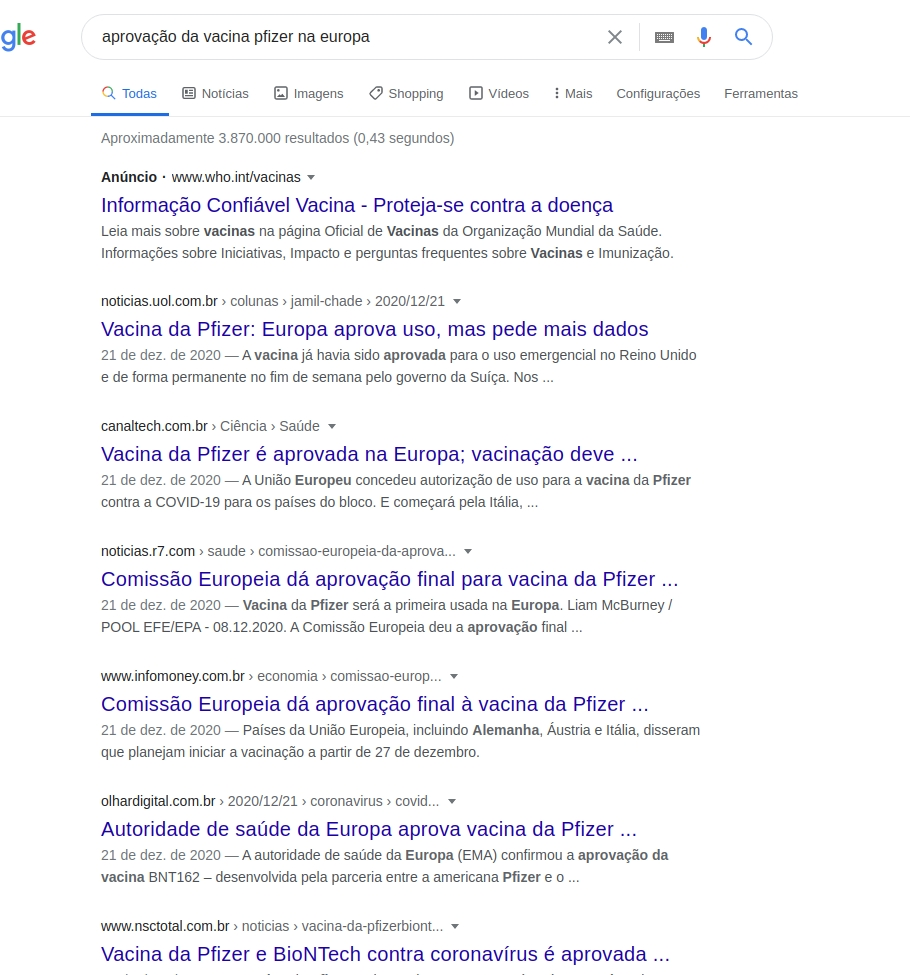

In [37]:
Image(filename='/home/leopoldo/Área de Trabalho/tweets pfizer/vacina.jpg', width=500, height=500)

Alguns dos tweets com sentimentos negativos no dia 01/01/2021

In [38]:
bad_day = pfizer[pfizer["date"]=="2021-01-01"]
bad_day = bad_day[bad_day["Sentimentos"]=="Negative"]
i=0
while i < 11:
    print(bad_day["text"].iloc[i])
    print("=======================================================================================")
    i += 1

DEATH BY VOLUNTARY LETHAL INJECTION. THANKS #Pfizer #PfizerVaccine #PfizerCovidVaccine #pfiexposed #PfizerBioNTech… https://t.co/prqtwXALsx
WHO lists Pfizer/BioNTech vaccine for emergency use #Esta #WHO #Coronavirus #CoronavirusVaccine #PfizerBioNTech 

https://t.co/2iburo8T3s
How do you ask a frail elderly vulnerable person to attend Vaccination centre with widespread community transmissio… https://t.co/0razXjxQ6D
What happened to "following the science"?? 😡 (Also, seriously? A u-turn on day one of 2021?)  #PfizerVaccine… https://t.co/IGaL5O9lDm
It’s on the #PfizerBioNTech notice in Belgium. Risk is under 1/1000. #AstraZeneca is not a mRNA vaccine and using a… https://t.co/d2IblhkcTZ
The #PfizerBioNTech #vaccine was trialed with a second dose at between 19 and 42 days. It is crazy to switch to a m… https://t.co/pcESGR1dvS
@MarkPawsey You need to answer serious questions about your continuing #ToryIncompetence over #Covid19UK… https://t.co/KlSpPs9sIh
Now 48 hrs out from dose 1. Arm sor

Alguns dos tweets das pessoas com sentimentos positivos no dia 22/12/2020. Alguns tweets comprovando a tese da vacina aprovada na Europa

In [39]:
good_day = pfizer[pfizer["date"]=="2020-12-22"]
good_day = good_day[good_day["Sentimentos"]=="Positive"]
i=0
while i < 11:
    print(good_day["text"].iloc[i])
    print("=======================================================================================")
    i += 1

Tiffany Dover is alive! 👀😃
#TiffanyDover #Pfizer #PfizerBioNTech #Pfizervaccine #VaccinoAntiCovid @CHI_Memorial… https://t.co/fN5UaouTNO
Biden tells Americans “there’s nothing to worry about”.

https://t.co/6hzPsRZmbS

@JoeBiden  @DrBiden @US_FDA… https://t.co/DL1RfeKBjr
Welcoming the first #PfizerBioNTech vaccines to #Oakville &amp; #Halton today! 

Thank you to our #HealthcareHeroes who… https://t.co/Mlf5BdeWZB
Happy to join the ranks of #Physiatry against COVID!  Vaccine 💉 part 1 - done ☑️   Thank you #PfizerBioNTech,… https://t.co/Y5v810WGue
was a real pleasure to volunteer on my post nights shift @RoyalFreeNHS to consent patients, staff and key workers a… https://t.co/4OUOQ6K9Jf
Well, I think it's clear we have a winner. #IQAward2020
"Healthcare worker administering the #vaccine did not reali… https://t.co/WYfcwas8g4
@MartinDaubney @mfogarty__ @guyverhofstadt I think #guyverhofstadt is sexy european name #eu #eu27 #europeanunion… https://t.co/WfR6gHuCUQ
Yay!! I got my COVID-19 vac

Agora será verificado da onde que são feitos os posts , para isso defini em realizar uma limpeza de dados nas localizações e agrupar por países. Exemplo de como as localizações são encontradas:

In [40]:
localizacoes_unicas = len(pfizer['user_location'].unique())
loc_unicas = pfizer['user_location'].unique()

In [41]:
i = 0
while i < 11:
    print(loc_unicas[i])
    i += 1

La Crescenta-Montrose, CA
San Francisco, CA
Your Bed
Vancouver, BC - Canada
No Location
Birmingham, England
Austria, Ukraine and Kosovo
Islamabad
Turkey-Israel
India
London, England


In [42]:
def limpa_estados(word, casesensitive="lower"):
    word = re.sub("\S*@\w*.com\S*", "", word)
    word = re.sub("@\S", "", word)
    word = re.sub("https\S*|www.\S", "", word)
    word = re.sub("[\d*\\+.#/:´^_@!;•]", "", word)
    word = re.sub("\$\S*|\(\S*\)", "",word)
    word = re.sub("\n", "", word)
    word = re.sub("https\S", "", word)
    word = re.sub("…", "", word)
    word = word.strip()
    if casesensitive=="lower":
        word = word.lower()
    return word

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def clean_location(x, simbolo):
    word = x.split(simbolo)[0]
    return string.capwords(word)

def return_location(word):
    estado = us.states.lookup(word)
    cidades_americanas = ["Usa", "Chicago", "Miami", "Los Angeles", "Atlanta", "Boston", "Houston", "Philadelphia", "San Francisco"]
    cidades_indianas = ["Mumbai", "New Delhi"]
    cidades_canadenses = ["Toronto", "Vancouver"]
    united_kingdom = ["England", "London", "Uk"]
    france = ["Paris"]
    arab_emirates = ["Dubai"]
    
    if (estado != None) or (word in cidades_americanas) :
        return "United States"
    elif word in cidades_indianas:
        return "India"
    elif word in cidades_canadenses:
        return "Canada"
    elif word in united_kingdom:
        return "United Kingdom"
    elif word in france:
        return "France"
    elif word in arab_emirates:
        return "United Arab Emirates"
    else:
        return str(word)

In [43]:
pfizer["estados"] = pfizer["user_location"].apply(lambda x: limpa_estados(x, "upper"))
pfizer["estados"] = pfizer["estados"].apply(lambda x: deEmojify(x))

simbolos = [",", "|", "+", "-"]
for simbolo in simbolos:
    pfizer["estados"] = pfizer["estados"].apply(lambda x: clean_location(x, simbolo))
pfizer["estados"] = pfizer["estados"].apply(lambda x: return_location(x))
localizacoes_unicas1 = len(pfizer['estados'].unique())
loc_unicas1 = pfizer['estados'].unique()

In [44]:
print(f"Total de localizações únicas antes da limpeza: {localizacoes_unicas}")
print("=======================================================")
print(f"Total de localizações únicas após a limpeza de dados: {localizacoes_unicas1}")
print("=======================================================")

Total de localizações únicas antes da limpeza: 909
Total de localizações únicas após a limpeza de dados: 678


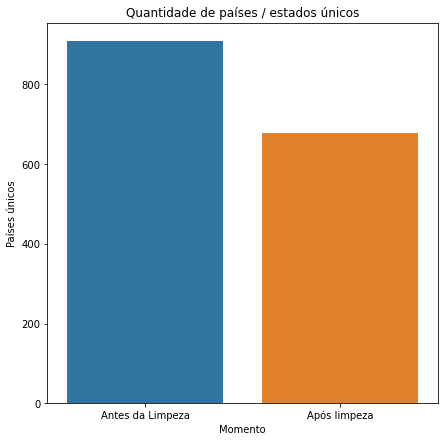

In [45]:
plt.figure(figsize=(7,7))
sns.barplot(y=[localizacoes_unicas, localizacoes_unicas1],x = ["Antes da Limpeza", "Após limpeza"] )
plt.title("Quantidade de países / estados únicos")
plt.xlabel("Momento")
plt.ylabel("Países únicos");

In [46]:
values_estados = pfizer["estados"].values
df_estados =pd.DataFrame(values_estados)
df_estados.columns = ["estados"]
df_estados["contador"] = 1
df_estados["estados"] = df_estados["estados"].astype(str)
estados = df_estados[df_estados["estados"]!=""]
estados = estados.groupby(by="estados").agg({"contador":"sum"})
estados = estados.sort_values(by="contador", ascending = False).reset_index()
estados_head = estados[:11]

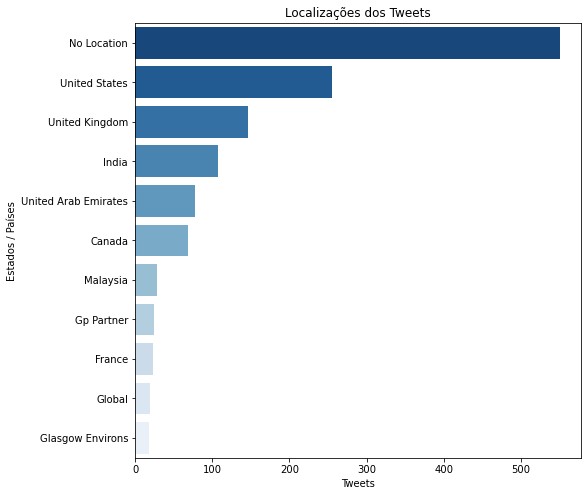

In [47]:
plt.figure(figsize=(8,8))
sns.barplot(y=estados_head["estados"], x='contador', data=estados_head, palette="Blues_r")
plt.title("Localizações dos Tweets")
plt.xlabel("Tweets")
plt.ylabel("Estados / Países");

In [48]:
max_retweets = pfizer[pfizer["retweets"]==max(pfizer["retweets"])]
user_name = max_retweets["user_name"].values
tweet = max_retweets["text"].values
sentiment_tweet = max_retweets["Sentimentos"].values
retweets = max_retweets["retweets"].values
favorites = max_retweets["favorites"].values
user_verified = max_retweets["user_verified"].values

In [49]:
print(f"==============Tweet com mais retweets============")
print("==================================================")
print(f"User Name: {user_name[0]}")
print(f"Tweet: {tweet[0]}")
print(f"Sentimento: {sentiment_tweet[0]}")
print(f"Retweets: {retweets[0]}")
print(f"Favorites: {favorites[0]}")
print(f"User verificado: {user_verified[0]}")

==============Tweet com mais retweets============
User Name: Charles Adler
Tweet: Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
Sentimento: Neutral
Retweets: 446
Favorites: 2129
User verificado: True


Gráfico a seguir demonstra o comprimento dos tweets com os sentimentos. Mostra também que não existe uma diferença siginifcativa no comprimento dos tweets quando se trata do sentimentos das pessoas.

<Figure size 720x720 with 0 Axes>

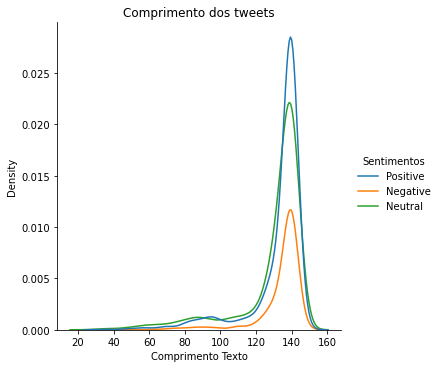

In [50]:
plt.figure(figsize=(10,10));
sns.displot(pfizer, x=pfizer["Comprimento Texto"], hue="Sentimentos", kind="kde");
plt.title("Comprimento dos tweets");

In [51]:
pfizer.groupby(by="Sentimentos").agg({"Comprimento Texto":"mean"})

,Comprimento Texto
Sentimentos,
Negative,134.043084
Neutral,129.343525
Positive,132.296094


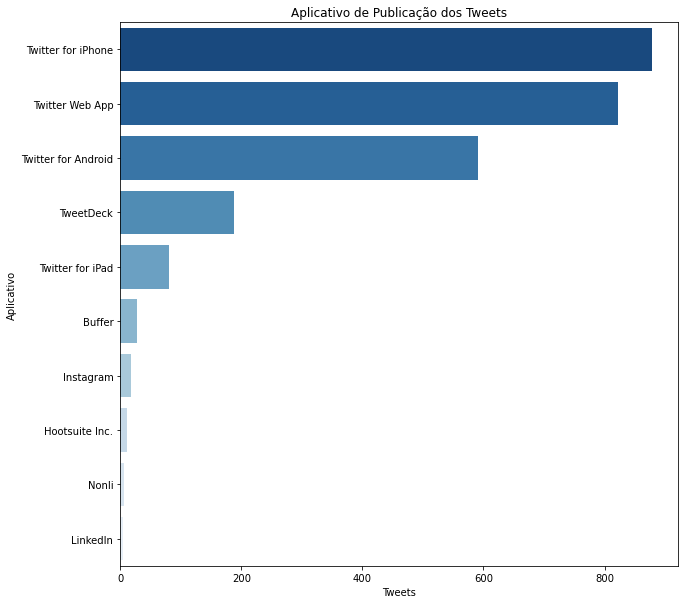

In [52]:
plt.figure(figsize=(10,10))
source = pfizer.groupby(by="source").count()["id"].sort_values(ascending = False).head(10)
sns.barplot(y = source.index, x = source.values, palette="Blues_r")
plt.title("Aplicativo de Publicação dos Tweets")
plt.ylabel("Aplicativo")
plt.xlabel("Tweets");